In [1]:
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
import Levenshtein as lev

import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform

import json

import pandas as pd
import re
import numpy as np
import time

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# load json of all pubmed data 
filepath='/home/jovyan/Petproject_KnowledgeGraphs/1_GetData/pubmed_data_query_antibody_drug_conjugate.json'
with open(filepath, 'r') as fp:
    data = json.load(fp)

# 0. description of approach
 - keywords are cleaned in a two-step effort
 - first, we remove obvious things such as hyphens, asterisks, etc through simple string manipulation and transform all words to their base form (nltk.stem.WordNetLemmatizer.lemmatize)
 - also, the first step deals with some obvious issues we are aware of, e.g. antibody drug conjugate = adc
 - second, we calculate the pairwise Levenshtein distances between all keywords. If a distance is below a certain threshold, the less abundant keyword becomes equal to the more abundant one

# 1. clean data

In [3]:
def clean_keyword_list(keywords):
    """ string manipulation of keywords, optimized to antibody-drug conjugate as a search term"""
    keywords=[k.strip("*") for k in keywords] #remove *
    keywords=[k.strip("'") for k in keywords] #remove '
    keywords=[k.replace("-"," ") for k in keywords] #remove -
    keywords=[k for k in keywords if not(k.lower()=="none")] #remove "none"
    lemmatizer=WordNetLemmatizer()
    keywords_temp=[]
    for k in keywords: 
        keywords_temp.append( ' '.join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(k)])) #to singular
    keywords=keywords_temp
    keywords=[k if not(k=="adc") else "antibody drug conjugate" for k in keywords] #adc=antibody drug conjugate
    regex=re.compile('antibody drug conjugate (.*)')
    keywords=[k if not(re.match(regex,k)) else "antibody drug conjugate" for k in keywords] #remove "antibody drug conjugate ( adc )"
    regex=re.compile('adc(.*)antibody drug conjugate(.*)')
    keywords=[k if not(re.match(regex,k)) else "antibody drug conjugate" for k in keywords] #remove "antibody drug conjugate ( adc )"
    regex=re.compile('adc(.*)antibody drug conjugate(.*)')
    keywords=[re.sub(r"[^\w]", " ", k) for k in keywords] #remove "periods"
    keywords=[re.sub(' +', ' ', k) for k in keywords] #remove multiple spaces
    keywords=[re.sub(' +', ' ', k).strip() for k in keywords] #remove multiple spaces and the trailing space
    keywords=[k if not(k=="adc") else "antibody drug conjugate" for k in keywords] #adc=antibody drug conjugate
    keywords=list(set(keywords)) #remove duplicates
    return keywords

def group_similar_keywords(keyword_list, dst_thresh):
    """function generates a mapping old keyword -> new keyword. In the majority of cases, the keyword will not
        change. We intend to replace the keywords that have a very similar equivalent. Example: siRNA vs si RNA.
        """
    # build a dataframe that contains all unique keywords and their abundance (counts) as columns
    df_keywords=pd.DataFrame(data=keyword_list,columns=['keyword'])
    df_keywords['counts']=1
    df_keywords=df_keywords.groupby('keyword').count().sort_values(by='counts', ascending=False).reset_index()
    print('Top 10 keywords before keyword matching:')
    print(df_keywords.head(10))

    # pairwise calculation of Levenshtein distances between keywords
    # fuzzywuzzy.sort_token_ration or similar may be an alternative to Levenshtein distances
    t0=time.time()
    print('##########################################################################\n')
    print('calculating Levenshtein distances...')
    keyword_list_unique=df_keywords['keyword'].values
    dst=pdist(np.array(keyword_list_unique).reshape(-1,1), lambda x,y: 1-lev.ratio(x[0],y[0]))
    print('done, time elapsed: %i s' % (time.time()-t0))
    
    # cluster together keywords with small distances below a threshold
    Z=sch.linkage(dst,'ward')
    cluster_assignments=sch.fcluster(Z,dst_thresh, criterion='distance')
    freq=np.bincount(cluster_assignments)
    cluster_ids=np.arange(len(freq))[freq>1]
    
    # build dataframe with list of similar keywords (n items) and the keyword they are replaced by as columns
    df_keywordcluster=pd.DataFrame(data=[],columns=['grouped_keywords','master_keyword'])
    for cid in cluster_ids:
        temp_keywordlist=keyword_list_unique[[np.arange(len(keyword_list_unique))[cluster_assignments==cid]]]
        temp_counts=[df_keywords.loc[lambda x: x.keyword==kw,'counts'].values[0] for kw in temp_keywordlist]
        temp_winner_keyword=temp_keywordlist[np.array(temp_counts).argmax()]
        df_keywordcluster=df_keywordcluster.append(pd.DataFrame([[temp_keywordlist,\
                                                                  temp_winner_keyword]],\
                                                                columns=df_keywordcluster.columns), ignore_index=True)

    print('Top 20 matched keywords:')
    print(df_keywordcluster.head(20).to_string())#  
    
    # first column is a list of keywords. each keyword should get its own row, so we need some pandas manipulation
    df_keywordcluster=pd.DataFrame(df_keywordcluster['grouped_keywords'].to_list(), index=df_keywordcluster.master_keyword).stack().reset_index(name='old_keyword')
    df_keywordcluster=df_keywordcluster.drop(columns=['level_1'])
    
    return df_keywordcluster

def replace_similar_keywords(keywords, df_keyword_simplification):
    for cnt,k in enumerate(keywords):
        if df_keyword_simplification['old_keyword'].isin([k]).sum():
             keywords[cnt]=df_keyword_simplification['master_keyword'][df_keyword_simplification['old_keyword'].isin([k])].values[0]

    return keywords



In [4]:
# first simple cleaning: string manipulations
print('simple cleaning: string manipulations')
print('initially %d keywords' % len(np.unique([kw for d in data for kw in d['keywords']])))

for cnt,d in enumerate(data):
    for key in d:
        if key == "keywords":
            data[cnt][key]=clean_keyword_list(d[key])
            
print('after cleaning %d keywords' % len(np.unique([kw for d in data for kw in d['keywords']])))

simple cleaning: string manipulations
initially 4769 keywords
after cleaning 4062 keywords


In [5]:
dst_thresh=0.1
keyword_list=[kw for d in data for kw in d['keywords']]
df_keyword_simplification=group_similar_keywords(keyword_list, dst_thresh)

print('initially %d keywords' % len(np.unique([kw for d in data for kw in d['keywords']])))
for cnt,d in enumerate(data):
    for key in d:
        if key == "keywords":
            data[cnt][key]=replace_similar_keywords(d[key],df_keyword_simplification)
        
print('after matching similar keywords: %d keywords' % len(np.unique([kw for d in data for kw in d['keywords']])))

Top 10 keywords before keyword matching:
                   keyword  counts
0  antibody drug conjugate     604
1      monoclonal antibody      86
2                 antibody      82
3      brentuximab vedotin      78
4                   cancer      62
5            immunotherapy      49
6                  vaccine      49
7            breast cancer      46
8           immunogenicity      44
9                     her2      43
##########################################################################

calculating Levenshtein distances...
done, time elapsed: 21 s


<ipython-input-3-021ddf6d5fbd>:54: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  temp_keywordlist=keyword_list_unique[[np.arange(len(keyword_list_unique))[cluster_assignments==cid]]]


Top 20 matched keywords:
                                                             grouped_keywords           master_keyword
0                                                         [sar3419, sar 3419]                  sar3419
1                                                             [sirna, dsirna]                    sirna
2                                                    [paediatrics, pediatric]              paediatrics
3                                                       [a1 mcmmaf, a1mcmmaf]                a1 mcmmaf
4                                                    [phase ib ii, phase iii]              phase ib ii
5   [phase 1 clinical trial, phase i clinical trial, phase ii clinical trial]   phase 1 clinical trial
6                                                     [casspase 3, caspase 3]               casspase 3
7                                                         [aptamer, aptamers]                  aptamer
8                                               

# build list of keywords that appear together

In [6]:
link_list_filepath= filepath[filepath.rindex('/')+1:][0:-5] + "_keywordlinks.csv"
link_list_clean_filepath= filepath[filepath.rindex('/')+1:][0:-5] + "_keywordlinks_clean.csv"
link_list_counted_filepath=filepath[filepath.rindex('/')+1:][0:-5] + "_keywordlinks_counted.csv"
count=len(data)
link_list=[]
link_list_clean=[]
cnt=0
for cnt, pubdata in enumerate(data): #loop through all publications and establish pairwise links of keywords
    keywords=pubdata['keywords']
    if not[]:
#         keywords=clean_keyword_list(keywords)
        for i in np.arange(0,len(keywords)-1):
            for k in np.arange(i+1,len(keywords)):
                keywordpair_temp=[keywords[i].lower(),keywords[k].lower()]  #alphabetical order to ensure that pairs A/B\
                                                                            #do not show as B/A
                                                                            #lower case to avoid issues with inconsistent
                                                                            #capitalization
                keywordpair_temp.sort()
                keywordpair_temp.append(pubdata['PMID']) #append PMID to avoid double-countings at a later stage
                link_list.append(keywordpair_temp)
                
    if not(cnt%1000):
        print("pairwise linking of keywords: %i of %i done" % (cnt, count))

     
#
link_list_df=pd.DataFrame(data=link_list,columns=["keyword1","keyword2","PMID"])
link_list_df.to_csv(link_list_filepath)
link_list_df=link_list_df.drop_duplicates()
link_list_df_counted=link_list_df.groupby(["keyword1","keyword2"]).count().reset_index() #count how often each pair appears
link_list_df_counted=link_list_df_counted.rename(columns={"PMID":"counts"})


print("established %i keyword links" % (len(link_list)))   
print("established %i unique keyword links" % (len(link_list_df)))
link_list_df_counted.to_csv(link_list_counted_filepath)

pairwise linking of keywords: 0 of 4762 done
pairwise linking of keywords: 1000 of 4762 done
pairwise linking of keywords: 2000 of 4762 done
pairwise linking of keywords: 3000 of 4762 done
pairwise linking of keywords: 4000 of 4762 done
established 34577 keyword links
established 34079 unique keyword links


In [7]:
# Export clean list of keywordpairs which will be used as import for the analytics pipeline
link_list_clean_df=link_list_df.drop(columns=["PMID"])
link_list_clean_df.to_csv(link_list_clean_filepath,index=False)  

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
uniquekeyword_series=pd.Series([item for d in data for item in d['keywords']])
uk=uniquekeyword_series.value_counts()
uk

antibody drug conjugate    606
monoclonal antibody         89
antibody                    82
brentuximab vedotin         78
cancer                      63
                          ... 
immune modulators            1
malaria vaccine              1
hybrid lba lc ms ms          1
ionizing radiation           1
                             1
Length: 3798, dtype: int64

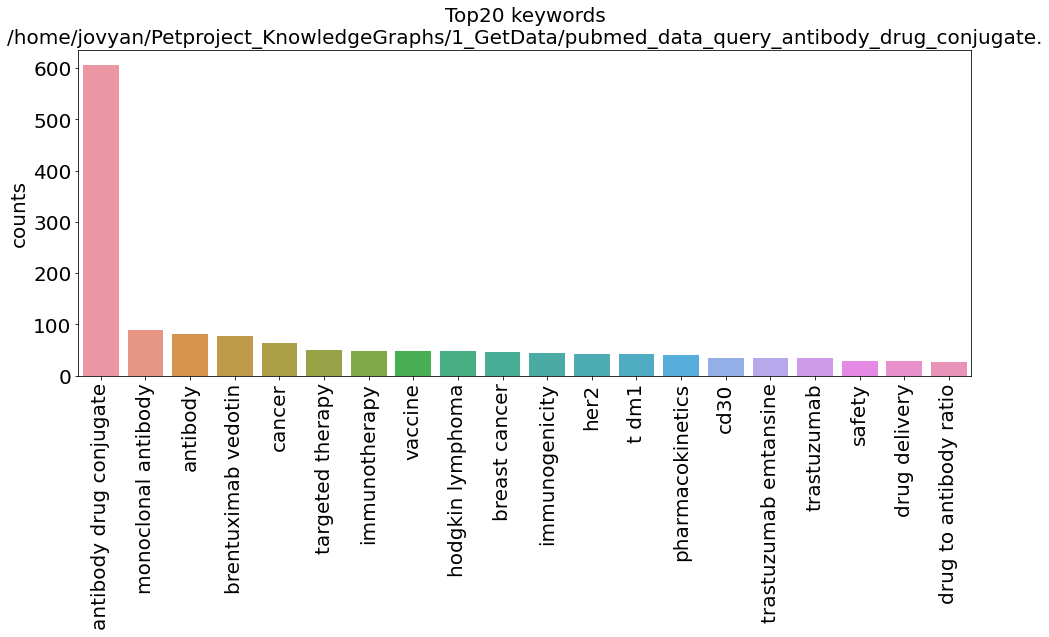

In [10]:
uniquekeyword_series=pd.Series([item for d in data for item in d['keywords']])
uk=uniquekeyword_series.value_counts()
maxcat=20
f=plt.figure(figsize=(16, 6))
ax=sns.barplot(x=uk.index[0:maxcat],y=uk.to_list()[0:maxcat])
for item in ax.get_xticklabels():
    item.set_rotation(90)
ax.set_title('Top20 keywords'+"\n"+filepath[0:-4],fontsize=20)
ax.set_ylabel('counts',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
f.savefig(filepath[filepath.rindex('/')+1:][0:-5]+"_topkeywords.png",bbox_inches='tight')

In [11]:
plt_df=link_list_df.copy()
plt_df['label']="["+plt_df['keyword1']+"] - ["+plt_df['keyword2'] + "]"
plt_df=plt_df.sort_values(by=['counts'], ascending=False)
plt_df['label']="["+plt_df['keyword1']+"] - ["+plt_df['keyword2'] + "]"
maxcat=20

f=plt.figure(figsize=(16, 6))
ax=sns.barplot(x=plt_df.iloc[0:maxcat]['label'],y=plt_df.iloc[0:maxcat]['counts'])
for item in ax.get_xticklabels():
    item.set_rotation(90)
ax.set_title('Top20 keyword pairs'+"\n"+filepath[0:-4], fontsize=20)
ax.set_ylabel('counts',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
f.savefig(filepath[filepath.rindex('/')+1:][0:-5]+"_topkeywordpairs.png",bbox_inches='tight')

KeyError: 'counts'